In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('dataset/kaggle_diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2000 non-null   int64  
 1   Glucose                   2000 non-null   int64  
 2   BloodPressure             2000 non-null   int64  
 3   SkinThickness             2000 non-null   int64  
 4   Insulin                   2000 non-null   int64  
 5   BMI                       2000 non-null   float64
 6   DiabetesPedigreeFunction  2000 non-null   float64
 7   Age                       2000 non-null   int64  
 8   Outcome                   2000 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 140.8 KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,2000.0,3.70350,3.306063,0.000,1.000,3.000,6.000,17.00
Glucose,2000.0,121.18250,32.068636,0.000,99.000,117.000,141.000,199.00
BloodPressure,2000.0,69.14550,19.188315,0.000,63.500,72.000,80.000,122.00
SkinThickness,2000.0,20.93500,16.103243,0.000,0.000,23.000,32.000,110.00
Insulin,2000.0,80.25400,111.180534,0.000,0.000,40.000,130.000,744.00
BMI,2000.0,32.19300,8.149901,0.000,27.375,32.300,36.800,80.60
DiabetesPedigreeFunction,2000.0,0.47093,0.323553,0.078,0.244,0.376,0.624,2.42
Age,2000.0,33.09050,11.786423,21.000,24.000,29.000,40.000,81.00
Outcome,2000.0,0.34200,0.474498,0.000,0.000,0.000,1.000,1.00


In [5]:
df.isnull().sum().any()

False

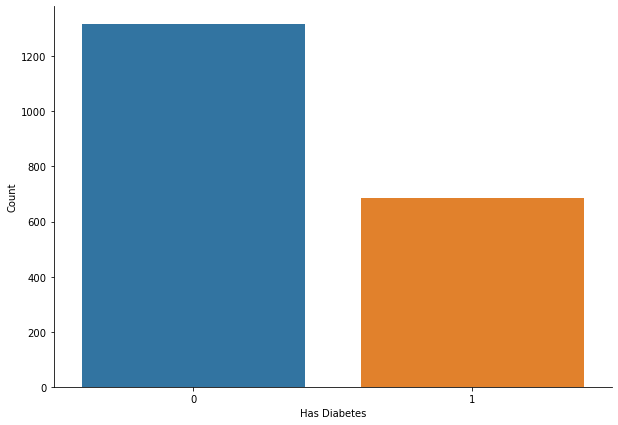

In [6]:
plt.figure(figsize=(10,7))
sns.countplot(x='Outcome', data=df)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Has Diabetes')
plt.ylabel('Count')
plt.show()

array([[<AxesSubplot:title={'center':'Pregnancies'}>,
        <AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'BloodPressure'}>],
       [<AxesSubplot:title={'center':'SkinThickness'}>,
        <AxesSubplot:title={'center':'Insulin'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'DiabetesPedigreeFunction'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Outcome'}>]], dtype=object)

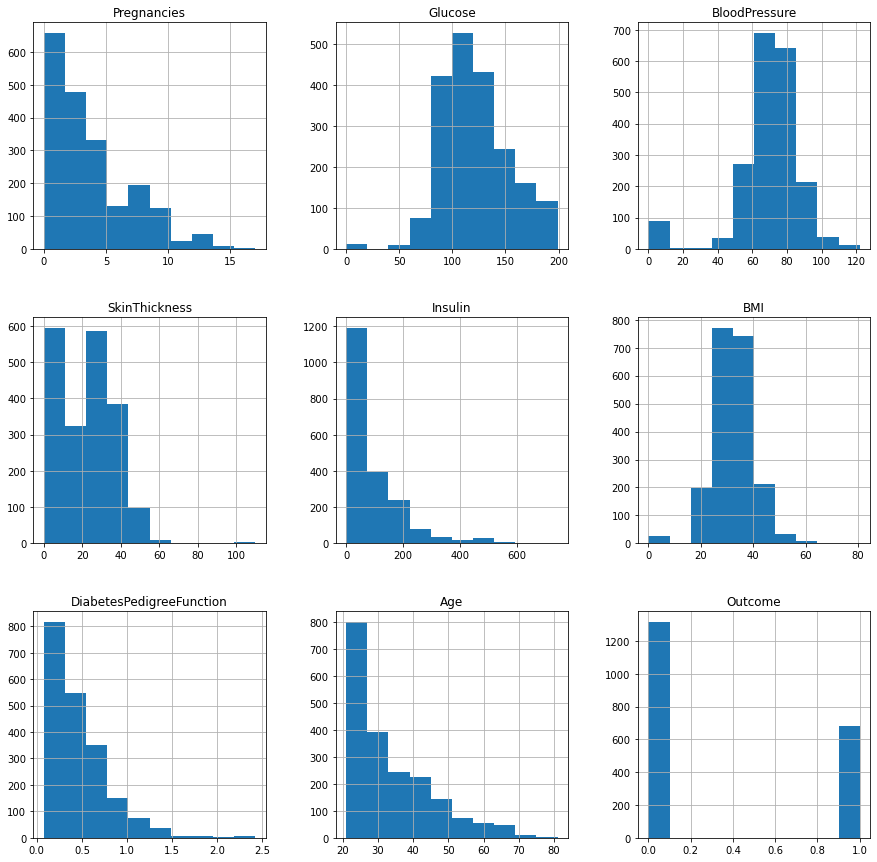

In [7]:
df.hist(figsize=(15,15))

In [8]:
from sklearn.model_selection import train_test_split
X = df.drop(columns='Outcome')
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [9]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [11]:
def find_best_model(X, y):
    models = {
        'logistic_regression': {
            'model': LogisticRegression(solver='lbfgs', multi_class='auto'),
            'parameters': {'C': [1,5,10]}
        },        
        'decision_tree': {
            'model': DecisionTreeClassifier(splitter='best'),
            'parameters': {'criterion': ['gini', 'entropy'],'max_depth': [5,10]}
        },
        'random_forest': {
            'model': RandomForestClassifier(criterion='gini'),
            'parameters': {'n_estimators': [10,15,20,50,100,200]
            }
        },
        'svm': {
            'model': SVC(gamma='auto'),
            'parameters': {'C': [1,10,20],'kernel': ['rbf','linear']}
        }
    }
    scores = [] 
    cv_shuffle = ShuffleSplit(n_splits=5, test_size=0.20, random_state=0)   
    for model_name, model_params in models.items():
        gs = GridSearchCV(model_params['model'], model_params['parameters'], cv = cv_shuffle, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model': model_name,
            'best_parameters': gs.best_params_,
            'score': gs.best_score_
        })
    return pd.DataFrame(scores, columns=['model','best_parameters','score'])
find_best_model(X_train, y_train)

,model,best_parameters,score
0,logistic_regression,{'C': 10},0.763125
1,decision_tree,"{'criterion': 'gini', 'max_depth': 10}",0.898750
2,random_forest,{'n_estimators': 100},0.949375
3,svm,"{'C': 20, 'kernel': 'rbf'}",0.869375


In [12]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(RandomForestClassifier(n_estimators=20, random_state=0), X_train, y_train, cv=5)
print('Average Accuracy : {}%'.format(round(sum(scores)*100/len(scores)), 3))

Average Accuracy : 95%


In [13]:
classifier = RandomForestClassifier(n_estimators=20, random_state=0)
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20, random_state=0)

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[272,   0],
       [  5, 123]], dtype=int64)

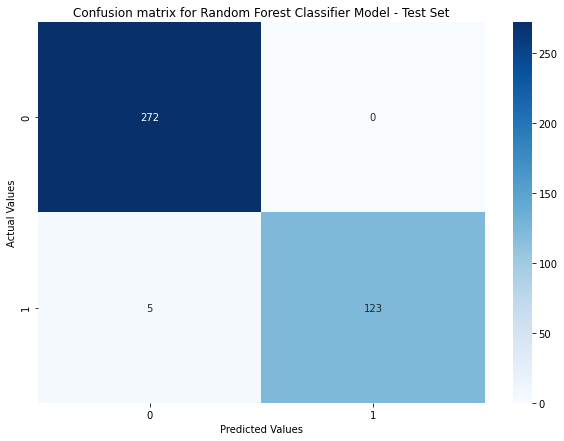

In [15]:
plt.figure(figsize=(10,7))
p = sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
plt.title('Confusion matrix for Random Forest Classifier Model - Test Set')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [16]:
score = round(accuracy_score(y_test, y_pred),4)*100
print("Accuracy on test set: {}%".format(score))

Accuracy on test set: 98.75%


In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       272
           1       1.00      0.96      0.98       128

    accuracy                           0.99       400
   macro avg       0.99      0.98      0.99       400
weighted avg       0.99      0.99      0.99       400



In [18]:
y_train_pred = classifier.predict(X_train)
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[1044,    0],
       [   1,  555]], dtype=int64)

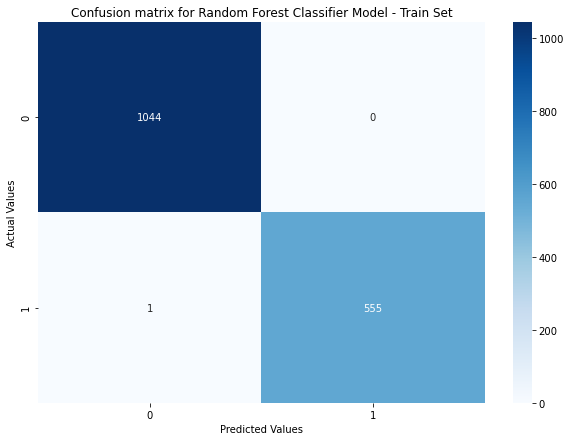

In [19]:
plt.figure(figsize=(10,7))
p = sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
plt.title('Confusion matrix for Random Forest Classifier Model - Train Set')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [20]:
score = round(accuracy_score(y_train, y_train_pred),4)*100
print("Accuracy on trainning set: {}%".format(score))

Accuracy on trainning set: 99.94%


In [21]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1044
           1       1.00      1.00      1.00       556

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600



In [22]:
def predict_diabetes(Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DPF, Age):
    preg = int(Pregnancies)
    glucose = float(Glucose)
    bp = float(BloodPressure)
    st = float(SkinThickness)
    insulin = float(Insulin)
    bmi = float(BMI)
    dpf = float(DPF)
    age = int(Age)
    x = [[preg, glucose, bp, st, insulin, bmi, dpf, age]]
    x = sc.transform(x)
    return classifier.predict(x)

In [23]:
prediction = predict_diabetes(2, 81, 72, 15, 76, 30.1, 0.547, 25)[0]
if prediction:
  print('Oops! You have diabetes.')
else:
  print("Great! You don't have diabetes.")

Great! You don't have diabetes.


C:\Users\Acer\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [24]:
prediction = predict_diabetes(1, 117, 88, 24, 145, 34.5, 0.403, 40)[0]
if prediction:
  print('Oops! You have diabetes.')
else:
  print("Great! You don't have diabetes.")

Oops! You have diabetes.


C:\Users\Acer\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [25]:
prediction = predict_diabetes(5, 120, 92, 10, 81, 26.1, 0.551, 67)[0]
if prediction:
  print('Oops! You have diabetes.')
else:
  print("Great! You don't have diabetes.")

Great! You don't have diabetes.


C:\Users\Acer\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
